<a href="https://colab.research.google.com/github/arshiabagchi/Resume-Screener/blob/main/Resume_Screener.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTING ALL LIBRARIES


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    precision_score, recall_score, mean_squared_error, r2_score
)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from scipy.sparse import hstack
import numpy as np

# DATASETS

In [ ]:
resumes = pd.read_csv('resumes_official.csv')
jobs = pd.read_csv('filtered_job_descriptions.csv')

# PREPROCESSING

In [ ]:
resumes['Combined'] = resumes['Skills'] + ' ' + resumes['Resume Text']
jobs['skills'] = jobs['skills'].fillna('')

# TF-IDF VECTORIZATION

In [ ]:
vectorizer = TfidfVectorizer()
resume_tfidf = vectorizer.fit_transform(resumes['Combined'])
job_tfidf = vectorizer.transform(jobs['skills'])

# STRONG/WEAK LABELS

In [ ]:
similarity_matrix = cosine_similarity(resume_tfidf, job_tfidf)

max_similarities = similarity_matrix.max(axis=1)

similarity_weight = 0.7
experience_weight = 0.3

resumes['Match'] = ((similarity_weight * (max_similarities >= 0.6)) +
                    (experience_weight * (resumes['Experience (Years)'] >= 2))).astype(int)

print(similarity_matrix)
print(resumes['Match'] )

[[0.         0.10305577 0.         ... 0.288789   0.3089784  0.20287389]
 [0.         0.11425034 0.         ... 0.         0.19486577 0.        ]
 [0.         0.10723327 0.         ... 0.30049544 0.03576628 0.        ]
 ...
 [0.         0.10635308 0.         ... 0.         0.46478774 0.20936491]
 [0.         0.09816149 0.         ... 0.13753698 0.16742457 0.        ]
 [0.         0.10775443 0.         ... 0.30195587 0.47091199 0.2121236 ]]
0      0
1      0
2      0
3      1
4      0
      ..
995    0
996    1
997    0
998    0
999    0
Name: Match, Length: 1000, dtype: int64


# EDA

# Skill Distribution

<ipython-input-6-7c5bba23d514>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=skill_freq.values, y=skill_freq.index, palette='viridis')


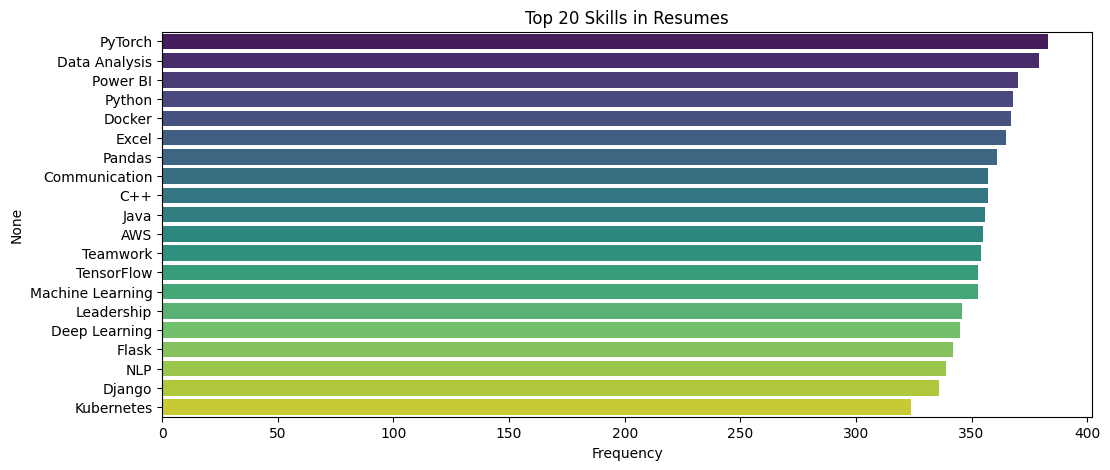

In [ ]:
skills_all = [skill.strip() for row in resumes['Skills'].str.split(',') for skill in row]
skill_freq = pd.Series(skills_all).value_counts().head(20)

plt.figure(figsize=(12,5))
sns.barplot(x=skill_freq.values, y=skill_freq.index, palette='viridis')
plt.title("Top 20 Skills in Resumes")
plt.xlabel("Frequency")
plt.show()

# Experience histogram

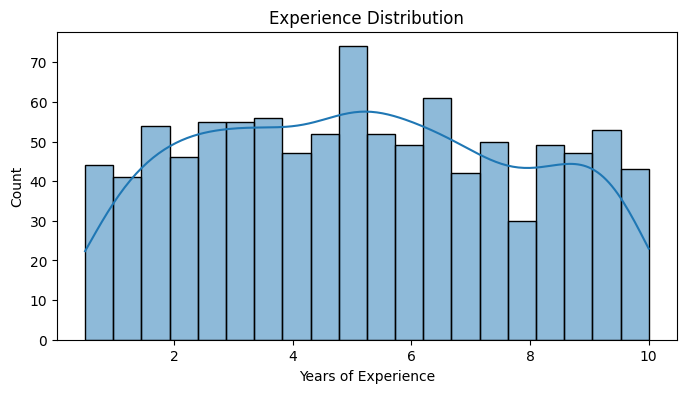

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(resumes['Experience (Years)'], bins=20, kde=True)
plt.title("Experience Distribution")
plt.xlabel("Years of Experience")
plt.show()

# Salary histogram

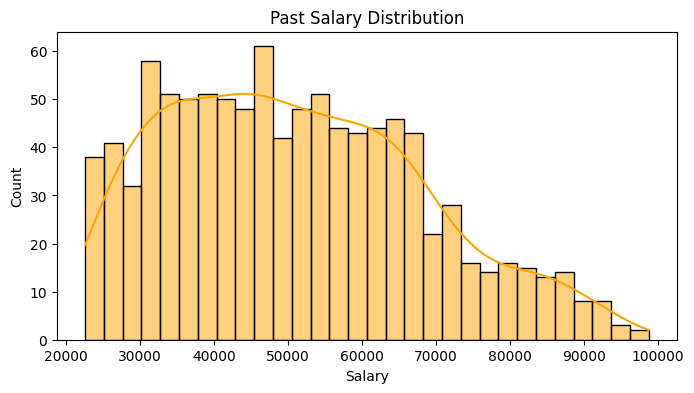

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(resumes['Past Salary (INR)'], bins=30, kde=True, color='orange')
plt.title("Past Salary Distribution")
plt.xlabel("Salary")
plt.show()

# TOP RESUME MATCHES FOR A JOB

In [ ]:
similarities = cosine_similarity(job_tfidf[110], resume_tfidf)[0]

top_k = 5
top_indices = np.argsort(similarities)[-top_k:][::-1]

top_resumes = resumes.iloc[top_indices].copy()
top_resumes['Similarity'] = similarities[top_indices]

print("\nTop 5 Resumes Matching Job 1 (based on skill overlap):")
print(top_resumes[['Name', 'Skills', 'Experience (Years)']])


Top 5 Resumes Matching Job 1 (based on skill overlap):
                 Name                                             Skills  \
264   Jennifer Taylor           Java, C++, Python, Flask, PyTorch, Excel   
690  Samantha Shepard     C++, Java, Docker, PyTorch, Leadership, Pandas   
129       Karla Ramos  Leadership, Java, C++, SQL, Flask, Python, Tea...   
569       Robert Cruz  Teamwork, Java, C++, Machine Learning, Leaders...   
691     Thomas Garcia            Leadership, Django, Java, Teamwork, C++   

     Experience (Years)  
264                 8.4  
690                 7.7  
129                 2.0  
569                 2.8  
691                 3.7  


# STRONG/WEAK CLASSIFICATION

# 1. SVM

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    resume_tfidf, resumes['Match'], test_size=0.2, random_state=42
)

svm = SVC(class_weight='balanced')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("\n SVM with Balanced Class Weights:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


 SVM with Balanced Class Weights:
Accuracy: 0.855
F1 Score: 0.6947368421052632
Precision: 0.6226415094339622
Recall: 0.7857142857142857
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       158
           1       0.62      0.79      0.69        42

    accuracy                           0.85       200
   macro avg       0.78      0.83      0.80       200
weighted avg       0.87      0.85      0.86       200



# 2. Logistic Regression

In [ ]:
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("\n Logistic Regression (Balanced Class Weights):")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("F1 Score:", f1_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log))
print("Recall:", recall_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


 Logistic Regression (Balanced Class Weights):
Accuracy: 0.75
F1 Score: 0.5535714285714286
Precision: 0.44285714285714284
Recall: 0.7380952380952381
              precision    recall  f1-score   support

           0       0.92      0.75      0.83       158
           1       0.44      0.74      0.55        42

    accuracy                           0.75       200
   macro avg       0.68      0.75      0.69       200
weighted avg       0.82      0.75      0.77       200



#3. Decision Tree

In [ ]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("\n Decision Tree Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


 Decision Tree Classifier:
Accuracy: 0.825
F1 Score: 0.5333333333333333
Precision: 0.6060606060606061
Recall: 0.47619047619047616
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       158
           1       0.61      0.48      0.53        42

    accuracy                           0.82       200
   macro avg       0.74      0.70      0.71       200
weighted avg       0.81      0.82      0.82       200



#SALARY PREDICTION

# 1. Linear Regression


 Linear Regression:
R² Score: 0.8116319489473461
MSE: 50299502.60736507
RMSE: 7092.214224582128


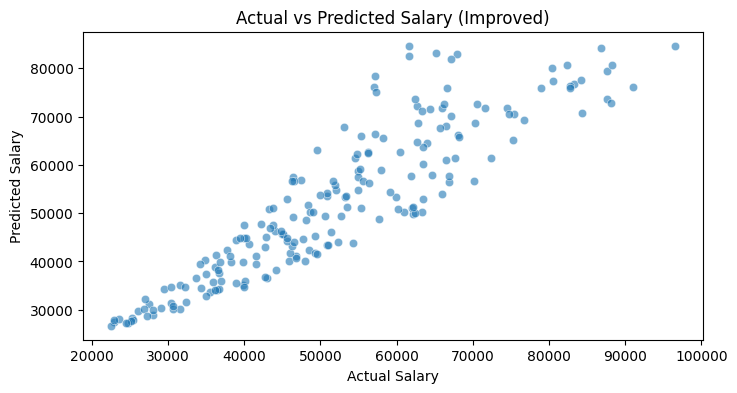

In [ ]:
resumes = resumes.dropna(subset=['Past Salary (INR)', 'Experience (Years)'])
resumes['Past Salary (INR)'] = resumes['Past Salary (INR)'].clip(lower=20000, upper=100000)
experience = resumes[['Experience (Years)']].values
X_salary = hstack([resume_tfidf, experience])
y_salary = np.log1p(resumes['Past Salary (INR)'])

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_salary, y_salary, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train_s, y_train_s)
log_salary_preds_lr = lr.predict(X_test_s)

salary_preds_lr = np.expm1(log_salary_preds_lr)
actual_salaries_lr = np.expm1(y_test_s)

print("\n Linear Regression:")
print("R² Score:", r2_score(actual_salaries_lr, salary_preds_lr))
print("MSE:", mean_squared_error(actual_salaries_lr, salary_preds_lr))
print("RMSE:", np.sqrt(mean_squared_error(actual_salaries_lr, salary_preds_lr)))


plt.figure(figsize=(8, 4))
sns.scatterplot(x=actual_salaries_lr, y=salary_preds_lr, alpha=0.6)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary (Improved)")
plt.show()

# 2. Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_s, y_train_s)

log_salary_preds = rf.predict(X_test_s)
salary_preds = np.expm1(log_salary_preds)
actual_salaries = np.expm1(y_test_s)

print("\n Random Forest:")
print("R² Score:", r2_score(actual_salaries, salary_preds))
print("MSE:", mean_squared_error(actual_salaries, salary_preds))
print("RMSE:", np.sqrt(mean_squared_error(actual_salaries, salary_preds)))


 Random Forest:
R² Score: 0.81072831134797
MSE: 50540798.94998756
RMSE: 7109.205226323655


# 3. Decision Tree Regressor

In [ ]:
dt_reg = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_reg.fit(X_train_s, y_train_s)
log_salary_preds_dt = dt_reg.predict(X_test_s)

salary_preds_dt = np.expm1(log_salary_preds_dt)
actual_salaries_dt = np.expm1(y_test_s)

print("\n Decision Tree Regressor:")
print("R² Score:", r2_score(actual_salaries_dt, salary_preds_dt))
print("MSE:", mean_squared_error(actual_salaries_dt, salary_preds_dt))
print("RMSE:", np.sqrt(mean_squared_error(actual_salaries_dt, salary_preds_dt)))


 Decision Tree Regressor:
R² Score: 0.6736651674074514
MSE: 87140466.07762936
RMSE: 9334.905788363874


# 4. KNN Regressor

In [ ]:
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_s, y_train_s)
log_salary_preds_knn = knn_reg.predict(X_test_s)

salary_preds_knn = np.expm1(log_salary_preds_knn)
actual_salaries_knn = np.expm1(y_test_s)

print("\n K-Nearest Neighbors Regressor:")
print("R² Score:", r2_score(actual_salaries_knn, salary_preds_knn))
print("MSE:", mean_squared_error(actual_salaries_knn, salary_preds_knn))
print("RMSE:", np.sqrt(mean_squared_error(actual_salaries_knn, salary_preds_knn)))


 K-Nearest Neighbors Regressor:
R² Score: 0.7951556605549701
MSE: 54699129.32920422
RMSE: 7395.885973242436


# SKILL GAP IDENTIFICATION

# 1. Decision Tree

Decision Tree Accuracy: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       158
           1       0.89      0.57      0.70        42

    accuracy                           0.90       200
   macro avg       0.89      0.78      0.82       200
weighted avg       0.89      0.90      0.89       200


Top Missing Skills (Weak vs Strong Candidates):
data          0.382725
learning      0.131348
sql           0.067439
aws           0.066555
excel         0.056228
python        0.051895
flask         0.044472
django        0.041950
pandas        0.040889
leadership    0.040848
dtype: float64


<ipython-input-17-ad4f53b3192c>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_skills.values, y=top_skills.index, palette='coolwarm')


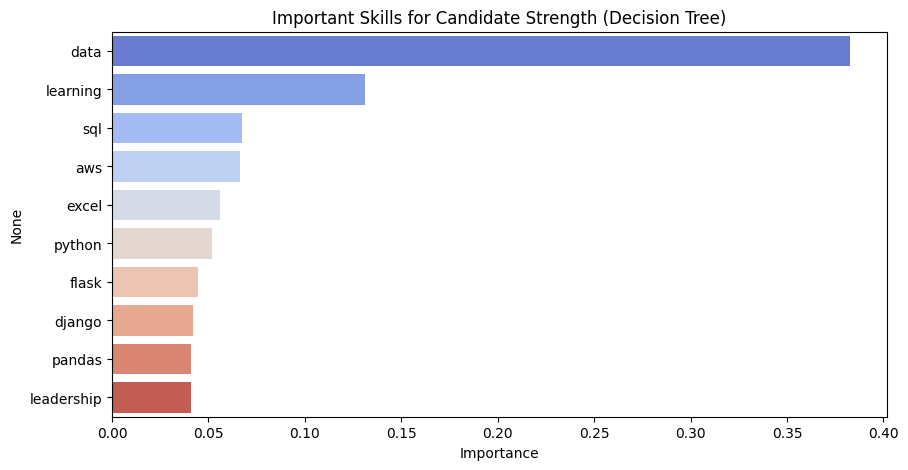

In [ ]:
skill_words = vectorizer.get_feature_names_out()
skill_df = pd.DataFrame(resume_tfidf.toarray(), columns=skill_words)
skill_df['Match'] = resumes['Match']

X_gaps = skill_df.drop(columns='Match')
y_gaps = skill_df['Match']

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_gaps, y_gaps, test_size=0.2, random_state=42)

tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train_g, y_train_g)
y_pred_g = tree.predict(X_test_g)

accuracy = accuracy_score(y_test_g, y_pred_g)
print(f"Decision Tree Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test_g, y_pred_g))

importances = tree.feature_importances_
top_skills = pd.Series(importances, index=X_gaps.columns).sort_values(ascending=False).head(10)

print("\nTop Missing Skills (Weak vs Strong Candidates):")
print(top_skills)

plt.figure(figsize=(10,5))
sns.barplot(x=top_skills.values, y=top_skills.index, palette='coolwarm')
plt.title("Important Skills for Candidate Strength (Decision Tree)")
plt.xlabel("Importance")
plt.show()

# 2. Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
rf.fit(X_train_g, y_train_g)
y_pred_rf = rf.predict(X_test_g)

accuracy_rf = accuracy_score(y_test_g, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print("\nClassification Report for Random Forest:")
print(classification_report(y_test_g, y_pred_rf))

importances_rf = rf.feature_importances_
top_skills_rf = pd.Series(importances_rf, index=X_gaps.columns).sort_values(ascending=False).head(10)

print("\nTop Missing Skills (Random Forest):")
print(top_skills_rf)

Random Forest Accuracy: 0.81

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       158
           1       0.65      0.26      0.37        42

    accuracy                           0.81       200
   macro avg       0.74      0.61      0.63       200
weighted avg       0.79      0.81      0.78       200


Top Missing Skills (Random Forest):
data             0.167981
analysis         0.161137
learning         0.079609
python           0.039447
communication    0.036171
strong           0.034387
with             0.034236
of               0.032467
experience       0.030167
aws              0.027543
dtype: float64


# 3. Logistic Regression

In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_g, y_train_g)
y_pred_lr = log_reg.predict(X_test_g)

accuracy_lr = accuracy_score(y_test_g, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.2f}")
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test_g, y_pred_lr))

coefficients = log_reg.coef_[0]
top_skills_lr = pd.Series(coefficients, index=X_gaps.columns).sort_values(ascending=False).head(10)

print("\nTop Missing Skills (Logistic Regression):")
print(top_skills_lr)

Logistic Regression Accuracy: 0.84

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       158
           1       0.78      0.33      0.47        42

    accuracy                           0.84       200
   macro avg       0.81      0.65      0.69       200
weighted avg       0.83      0.84      0.81       200


Top Missing Skills (Logistic Regression):
analysis         2.964249
data             2.964249
python           2.133781
communication    1.259200
aws              1.035908
learning         0.500716
leadership       0.393215
mba              0.388276
machine          0.348284
deep             0.317362
dtype: float64
